Cristobal Gomez y Pepe López pppppppp

# Proyecto de predicción de contratación de productos para clientes de un banco

## Importe de librerias

In [119]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import h2o
from h2o.automl import H2OAutoML
import numpy as np
from scoring import mapk, apk


## 1. Importación y Exploración Inicial de los Datos


### 1.1. Importación de los Datos

In [120]:

# Cargar datos
dataset = pd.read_csv('dataset_para_modelar.csv')

C:\Users\pepei\AppData\Local\Temp\ipykernel_24216\355871677.py:2: DtypeWarning: Columns (5,9,11) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('dataset_para_modelar.csv')


### 1.2. Exploración Inicial


Mostrar información básica del dataset


In [121]:
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634682 entries, 0 to 634681
Data columns (total 49 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             634682 non-null  int64  
 1   cod_persona            634682 non-null  int64  
 2   mes                    634682 non-null  object 
 3   pais                   634626 non-null  object 
 4   sexo                   634617 non-null  object 
 5   edad                   634682 non-null  object 
 6   fecha1                 634626 non-null  object 
 7   xti_empleado           634626 non-null  object 
 8   xti_nuevo_cliente      634626 non-null  float64
 9   num_antiguedad         634682 non-null  object 
 10  xti_rel                634626 non-null  float64
 11  fec_ult_cli_1t         36 non-null      object 
 12  xti_rel_1mes           629040 non-null  float64
 13  tip_rel_1mes           629040 non-null  object 
 14  indresi                634626 non-nu

Descripcion de las principales metricas de cada variable

In [122]:
dataset.describe()


,Unnamed: 0,cod_persona,xti_nuevo_cliente,xti_rel,xti_rel_1mes,tip_dom,cod_provincia,xti_actividad_cliente,imp_renta,mean_engagement,ind_prod1,ind_prod2,ind_prod3,ind_prod4,ind_prod5,ind_prod6,ind_prod7,ind_prod8,ind_prod9,ind_prod10,ind_prod11,ind_prod12,ind_prod13,ind_prod14,ind_prod15,ind_prod16,ind_prod17,ind_prod18,ind_prod19,ind_prod20,ind_prod21,ind_prod22,ind_prod23,ind_prod24,ind_prod25
count,634682.000000,6.346820e+05,634626.000000,634626.000000,629040.000000,634626.0,631736.000000,634626.000000,5.105180e+05,629040.000000,634682.000000,634682.0,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634682.000000,634651.000000,634651.000000,634682.000000,634682.000000
mean,321920.356254,7.217769e+05,0.059846,1.005559,1.000587,1.0,26.598741,0.459126,1.367071e+05,6.425623,0.000101,0.0,0.660945,0.000495,0.081740,0.009992,0.009825,0.131909,0.043504,0.002036,0.001899,0.043438,0.083139,0.018698,0.005275,0.009263,0.002718,0.053576,0.045505,0.026503,0.003756,0.055561,0.060295,0.128827,0.065876
std,185232.719038,4.290892e+05,0.237202,0.738085,0.036560,0.0,12.777667,0.498327,3.339545e+05,1.345879,0.010041,0.0,0.473389,0.022237,0.273969,0.099461,0.098635,0.338392,0.203988,0.045072,0.043531,0.203840,0.276093,0.135455,0.072438,0.095797,0.052063,0.225180,0.208408,0.160626,0.061173,0.229073,0.238032,0.335008,0.248065
min,0.000000,5.514000e+03,0.000000,1.000000,0.000000,1.0,1.000000,0.000000,4.559550e+03,0.218520,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,161691.250000,3.584120e+05,0.000000,1.000000,1.000000,1.0,15.000000,0.000000,6.821148e+04,5.117500,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,322352.500000,6.230450e+05,0.000000,1.000000,1.000000,1.0,28.000000,0.000000,1.012905e+05,6.463518,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,482540.750000,1.102693e+06,0.000000,1.000000,1.000000,1.0,35.000000,1.000000,1.566742e+05,7.359949,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,641706.000000,1.537800e+06,1.000000,99.000000,4.000000,1.0,52.000000,1.000000,2.889440e+07,38.793123,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Primera visualizacion de las variables

In [123]:
dataset.head(500)

,Unnamed: 0,cod_persona,mes,pais,sexo,edad,fecha1,xti_empleado,xti_nuevo_cliente,num_antiguedad,xti_rel,fec_ult_cli_1t,xti_rel_1mes,tip_rel_1mes,indresi,indext,des_canal,xti_extra,tip_dom,cod_provincia,xti_actividad_cliente,imp_renta,id_segmento,mean_engagement,ind_prod1,ind_prod2,ind_prod3,ind_prod4,ind_prod5,ind_prod6,ind_prod7,ind_prod8,ind_prod9,ind_prod10,ind_prod11,ind_prod12,ind_prod13,ind_prod14,ind_prod15,ind_prod16,ind_prod17,ind_prod18,ind_prod19,ind_prod20,ind_prod21,ind_prod22,ind_prod23,ind_prod24,ind_prod25
0,0,178103,2015-01-28,ES,H,35,2015-01-12,N,0.0,6,1.0,NaN,1.0,A,S,N,KHL,N,1.0,29.0,1.0,87218.10,02 - PARTICULARES,6.134600,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
1,1,503082,2015-01-28,ES,V,27,2012-08-10,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,40.0,0.0,70777.59,03 - UNIVERSITARIO,5.414673,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
2,2,502996,2015-01-28,ES,V,37,2012-08-10,N,0.0,35,1.0,NaN,1.0,A,S,N,KFC,N,1.0,8.0,0.0,104035.08,02 - PARTICULARES,6.301283,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
3,3,503053,2015-01-28,ES,H,23,2012-08-10,N,0.0,35,1.0,NaN,1.0,A,S,N,KHE,N,1.0,39.0,1.0,136930.23,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0
4,4,503031,2015-01-28,ES,H,44,2012-08-10,N,0.0,35,1.0,NaN,1.0,I,S,N,KAT,N,1.0,28.0,0.0,110245.53,02 - PARTICULARES,6.851770,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,500,507107,2015-01-28,ES,V,23,2012-08-07,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,8.0,0.0,NaN,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
496,501,507098,2015-01-28,ES,V,41,2012-08-08,N,0.0,35,1.0,NaN,1.0,A,S,N,KHE,N,1.0,33.0,1.0,106812.69,02 - PARTICULARES,6.621644,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
497,502,507113,2015-01-28,ES,V,23,2012-08-07,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,8.0,0.0,NaN,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0
498,503,507130,2015-01-28,ES,V,23,2012-08-07,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,8.0,0.0,195216.72,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0


## 2. Limpieza de Datos


### 2.1. Manejo de Formatos


In [124]:
dataset[['ind_prod23', 'ind_prod22']].astype('Int64')

# Paso la columna 'mes' a datetime
dataset['mes'] = pd.to_datetime(dataset['mes'], format='%Y-%m-%d')
#Extraemos las caracteristicas de mes, dia y año:
dataset['mes_mes']=dataset['mes'].dt.month
dataset['mes_año']=dataset['mes'].dt.year

In [125]:
#dataset[cod_persona]=503082 y ordenarlo por fecha1:

#Ejemplo de una persona
dataset[dataset['cod_persona']==504546].sort_values(by='fecha1')

,Unnamed: 0,cod_persona,mes,pais,sexo,edad,fecha1,xti_empleado,xti_nuevo_cliente,num_antiguedad,xti_rel,fec_ult_cli_1t,xti_rel_1mes,tip_rel_1mes,indresi,indext,des_canal,xti_extra,tip_dom,cod_provincia,xti_actividad_cliente,imp_renta,id_segmento,mean_engagement,ind_prod1,ind_prod2,ind_prod3,ind_prod4,ind_prod5,ind_prod6,ind_prod7,ind_prod8,ind_prod9,ind_prod10,ind_prod11,ind_prod12,ind_prod13,ind_prod14,ind_prod15,ind_prod16,ind_prod17,ind_prod18,ind_prod19,ind_prod20,ind_prod21,ind_prod22,ind_prod23,ind_prod24,ind_prod25,mes_mes,mes_año
62,62,504546,2015-01-28,ES,H,23,2012-08-09,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,1,2015
61530,62846,504546,2015-02-28,ES,H,23,2012-08-09,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,2,2015
91495,93386,504546,2015-03-28,ES,H,23,2012-08-09,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,3,2015
123869,126332,504546,2015-04-28,ES,H,23,2012-08-09,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,4,2015
125782,128260,504546,2015-05-28,ES,H,23,2012-08-09,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,5,2015
157209,160210,504546,2015-06-28,ES,H,23,2012-08-09,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,6,2015
216829,220553,504546,2015-07-28,ES,H,23,2012-08-09,N,0.0,35,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.014352,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,7,2015
254727,259089,504546,2015-08-28,ES,H,24,2012-08-09,N,0.0,36,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.117500,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,8,2015
300440,305168,504546,2015-09-28,ES,H,24,2012-08-09,N,0.0,37,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.117500,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,9,2015
322426,327473,504546,2015-10-28,ES,H,24,2012-08-09,N,0.0,38,1.0,NaN,1.0,I,S,N,KHE,N,1.0,9.0,0.0,NaN,03 - UNIVERSITARIO,5.117500,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0,0,10,2015


In [126]:
print(dataset['xti_extra'].value_counts()) #Casi todas las personas se consideran que estan vivas por lo que no aporta informac

xti_extra
N    633108
S      1518
Name: count, dtype: int64


In [127]:
print(dataset['tip_dom'].value_counts()) #Todas las personas tienen un domicilio particular por lo que no aporta informacion

tip_dom
1.0    634626
Name: count, dtype: int64


In [128]:
print(dataset['Unnamed: 0'].value_counts()) # No aporta información por lo que son las filas que se han añadido al cargar el dataset

Unnamed: 0
0         1
429174    1
429167    1
429168    1
429169    1
         ..
215231    1
215232    1
215233    1
215235    1
641706    1
Name: count, Length: 634682, dtype: int64


In [129]:

# Eliminar columnas innecesarias
columns_to_drop = ['Unnamed: 0', 'xti_extra', 'tip_dom']

# Unnamed la elimino porque es un índice que se ha guardado en el csv
# xti_extra la elimino porque es una variable que no aporta información ya que la mayoría de los registros son personas vivas
# tip_dom la elimino porque es una variable que no aporta información ya que no aporta informacion, todas son 1

dataset.drop(columns=columns_to_drop, inplace=True)


In [130]:
dataset['pais'].value_counts()


pais
ES    631736
DE       285
GB       244
FR       224
US       203
CH       192
CO       160
AR       144
IT       138
MX       122
RO       104
EC        90
VE        80
CL        74
PY        74
BE        64
BR        52
AT        48
CA        48
FI        32
NL        32
PL        32
CN        32
PE        32
BG        32
BO        26
GT        16
PK        16
PT        16
GN        16
PR        16
JP        16
IL        16
SA        16
NG        16
NZ        16
IN        16
AD        16
UA        16
SE        16
GE        16
CU        16
PA        16
SV        16
AU        11
MD        10
RU        10
HU         7
Name: count, dtype: int64

Se observa como la mayoría de los registros son de España, resultando el resto de paises en cifras no significativas. Se podría considerar la posibilidad de agrupar los paises con menos registros en un grupo llamado "Otros" para reducir la dimensionalidad de la variable y se mapea a 0-1. 

In [131]:
# Crear un diccionario de mapeo para agrupar los países
#Si pais es España el valor de la columna pais_es será 1, sino 0:
dataset['pais_binario'] = dataset['pais'].apply(lambda x: 1 if x == 'ES' else 0)
dataset.drop(columns=['pais'], inplace=True)
dataset['pais_binario'].value_counts()


pais_binario
1    631736
0      2946
Name: count, dtype: int64

In [132]:
# Crear un diccionario de mapeo para asignar números a cada género
mapping_sex = {'V': 1, 'H': 0}

# Aplicar el mapeo a la columna 'customer_sex'
dataset['sexo'] = dataset['sexo'].map(mapping_sex)

In [133]:
dataset['sexo'].value_counts()


sexo
1.0    346845
0.0    287772
Name: count, dtype: int64

In [134]:
dataset['imp_renta'].max()

28894395.51

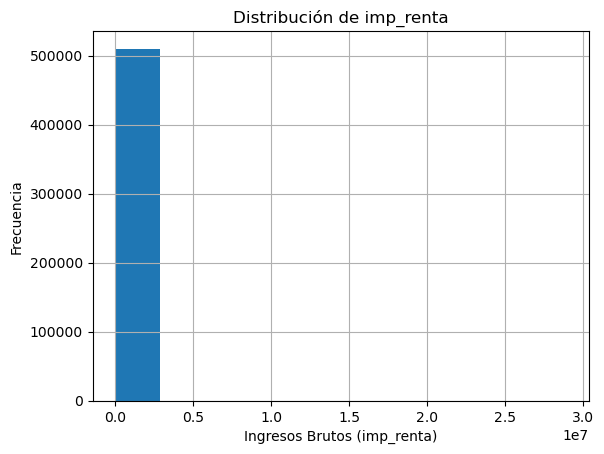

In [135]:
dataset['imp_renta'].hist()
plt.title('Distribución de imp_renta')
plt.xlabel('Ingresos Brutos (imp_renta)')
plt.ylabel('Frecuencia')
plt.show()

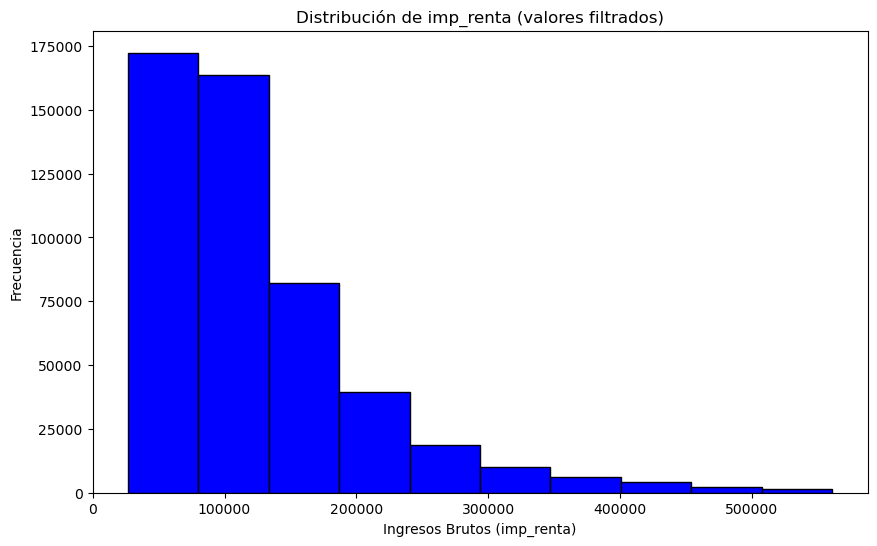

In [136]:
# Filtrar los valores extremos
q_low = dataset['imp_renta'].quantile(0.01)
q_high = dataset['imp_renta'].quantile(0.99)
filtered_data = dataset[(dataset['imp_renta'] >= q_low) & (dataset['imp_renta'] <= q_high)]

# Crear el histograma con los datos filtrados
plt.figure(figsize=(10, 6))
plt.hist(filtered_data['imp_renta'], color='blue', edgecolor='black')
plt.title('Distribución de imp_renta (valores filtrados)')
plt.xlabel('Ingresos Brutos (imp_renta)')
plt.ylabel('Frecuencia')
plt.show()

Es una distribución completamente sesgada (right-skewed) donde los valores se concentran en la parte baja de la distribución.
Podríamos considerar la posibilidad de aplicar una transformación logarítmica para reducir el sesgo y mejorar la distribución de los datos.

In [137]:
#Recuento de nulos por columna:
dataset.isnull().sum().sort_values(ascending=False)

fec_ult_cli_1t           634646
imp_renta                124164
id_segmento                7403
des_canal                  7178
tip_rel_1mes               5642
mean_engagement            5642
xti_rel_1mes               5642
cod_provincia              2946
sexo                         65
xti_actividad_cliente        56
indext                       56
indresi                      56
xti_rel                      56
xti_nuevo_cliente            56
xti_empleado                 56
fecha1                       56
ind_prod23                   31
ind_prod22                   31
ind_prod20                    0
ind_prod16                    0
ind_prod17                    0
ind_prod15                    0
ind_prod18                    0
ind_prod19                    0
cod_persona                   0
ind_prod21                    0
ind_prod24                    0
ind_prod25                    0
ind_prod13                    0
mes_mes                       0
mes_año                       0
ind_prod

In [138]:
##Notificamos que fec_ult_cli_1t tiene casi el 100% de los valores nulos, por lo que se elimina
dataset.drop(columns=['fec_ult_cli_1t'], inplace=True)

### xti_rel

In [139]:
dataset['xti_rel'] = pd.to_numeric(dataset['xti_rel'], errors='coerce')
dataset['xti_rel'].value_counts()


xti_rel
1.0     634590
99.0        36
Name: count, dtype: int64

In [140]:
dataset['xti_rel'].fillna(1, inplace=True)

In [141]:
dataset['xti_rel'] = dataset['xti_rel'].apply(lambda x: 1 if x == 1 else 0)
dataset['xti_rel'].value_counts()

xti_rel
1    634646
0        36
Name: count, dtype: int64

### xti_rel_1mes

In [142]:
dataset['xti_rel_1mes'] = pd.to_numeric(dataset['xti_rel_1mes'], errors='coerce')


In [143]:
dataset['xti_rel_1mes'].value_counts()

xti_rel_1mes
1.0    628777
3.0       158
2.0        53
0.0        39
4.0        13
Name: count, dtype: int64

In [144]:
dataset['xti_rel_1mes'] = dataset['xti_rel_1mes'].apply(lambda x: 1 if x == 1 else 0)
dataset['xti_rel_1mes'].value_counts()

xti_rel_1mes
1    628777
0      5905
Name: count, dtype: int64

Casi todos los valores son 1. 

## mean_engagement, tip_rel_1mes, 

In [145]:
dataset['mean_engagement'].value_counts()


mean_engagement
5.014352     36820
4.908936     34341
5.117500     33567
4.801096     30474
5.218520     21611
             ...  
24.774578        1
38.793123        1
15.966536        1
17.711376        1
12.867631        1
Name: count, Length: 203, dtype: int64

In [146]:
dataset['tip_rel_1mes'].value_counts()

tip_rel_1mes
I    340711
A    288119
P       171
R        39
Name: count, dtype: int64


### xti_empleado
lo consideramos como una variable binaria porque casi todos los valores se concentran en N

In [147]:
dataset['xti_empleado'].value_counts()


xti_empleado
N    634158
A       202
B       170
F        96
Name: count, dtype: int64

In [148]:
dataset['xti_empleado'] = dataset['xti_empleado'].apply(lambda x: 1 if x == 'N' else 0)
dataset['xti_empleado'].value_counts()

xti_empleado
1    634158
0       524
Name: count, dtype: int64

### num_antiguedad
Comprobamos la variable num_antiguedad: 

In [149]:
dataset['num_antiguedad'] = pd.to_numeric(dataset['num_antiguedad'], errors='coerce')


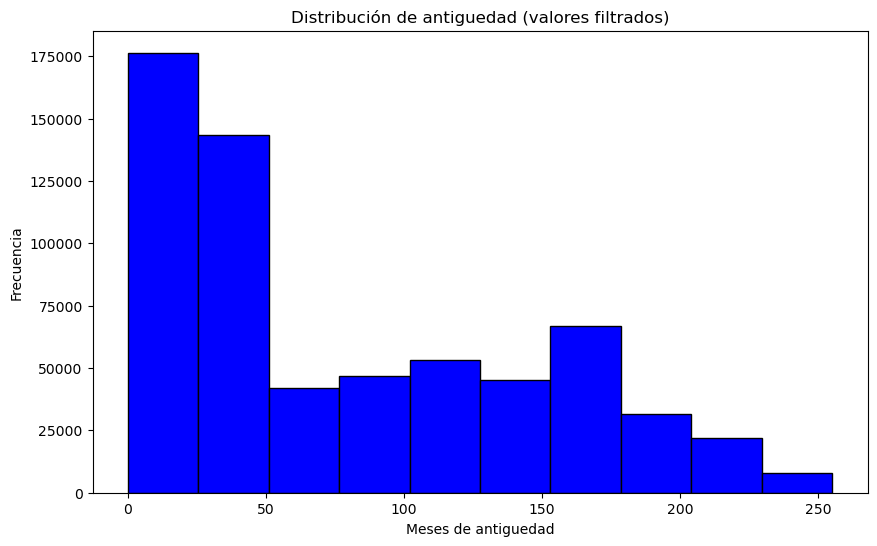

In [150]:
plt.figure(figsize=(10, 6))  # Create a figure with desired size
plt.hist(dataset['num_antiguedad'], bins=10, color='blue', edgecolor='black')  

plt.title('Distribución de antiguedad (valores filtrados)')  
plt.xlabel('Meses de antiguedad')  
plt.ylabel('Frecuencia')  

plt.show()  

In [151]:
pd.set_option('display.max_columns', None)
print(dataset.head(5))

   cod_persona        mes  sexo edad      fecha1  xti_empleado  \
0       178103 2015-01-28   0.0   35  2015-01-12             1   
1       503082 2015-01-28   1.0   27  2012-08-10             1   
2       502996 2015-01-28   1.0   37  2012-08-10             1   
3       503053 2015-01-28   0.0   23  2012-08-10             1   
4       503031 2015-01-28   0.0   44  2012-08-10             1   

   xti_nuevo_cliente  num_antiguedad  xti_rel  xti_rel_1mes tip_rel_1mes  \
0                0.0             6.0        1             1            A   
1                0.0            35.0        1             1            I   
2                0.0            35.0        1             1            A   
3                0.0            35.0        1             1            A   
4                0.0            35.0        1             1            I   

  indresi indext des_canal  cod_provincia  xti_actividad_cliente  imp_renta  \
0       S      N       KHL           29.0                    1.0   

Calcular los valores de la moda y la mediana


ESTO ES MIERDA! NO FUNCIONA

In [152]:
most_frequent_xti_rel_1mes = dataset['xti_rel_1mes'].mode()[0]
most_frequent_tip_rel_1mes = dataset['tip_rel_1mes'].mode()[0]
median_engagement_score = dataset['mean_engagement'].median()

Rellenar valores nulos con los valores calculados


In [153]:
dataset['xti_rel_1mes'].fillna(most_frequent_xti_rel_1mes, inplace=True)
dataset['tip_rel_1mes'].fillna(most_frequent_tip_rel_1mes, inplace=True)
dataset['mean_engagement'].fillna(median_engagement_score, inplace=True)

Reemplazar valores nulos en cod_provincia por 0


In [154]:
dataset['cod_provincia'].fillna(0, inplace=True)


Convertir las provincias categóricas a números


In [155]:
dataset['cod_provincia'] = dataset['cod_provincia'].astype('category').cat.codes

In [156]:
# Limpiar datos
dataset['edad'].fillna(dataset['edad'].mean(), inplace=True)
#Rellenamos con la media porque se considera mas representativa 
# dataset['imp_renta'].fillna(dataset['imp_renta'].median(), inplace=True) 
#Rellenamos con mediana porque existen outliers muy elevados que sesgarian el valor si rellenamos con la media los valores faltantes 

"""
Se añade el codigo para una visualizacion de la distribución logaritmica por si quisiera visualizarse
"""
# transformed_data = np.log1p(dataset['imp_renta'])  # log1p aplica log(1 + x) para manejar valores de 0
# plt.hist(transformed_data)
# plt.title('Distribución transformada de imp_renta (log)')
# plt.xlabel('Log(imp_renta)')
# plt.ylabel('Frecuencia')
# plt.show()

TypeError: can only concatenate str (not "int") to str

In [ ]:
# Feature Engineering
dataset['nueva_caracteristica'] = dataset['edad'] * dataset['imp_renta']

# Verificar cambios
print(dataset.head())

In [ ]:
# Convertir columnas con valores mixtos a numéricos
dataset['num_antiguedad'] = pd.to_numeric(dataset['num_antiguedad'], errors='coerce')
dataset['num_antiguedad'].fillna(dataset['num_antiguedad'].mean(), inplace=True)
dataset['xti_rel_1mes'] = pd.to_numeric(dataset['xti_rel_1mes'], errors='coerce')
dataset['xti_rel_1mes'].fillna(dataset['xti_rel_1mes'].mean(), inplace=True)

# Convertir columnas categóricas en variables dummy
categorical_columns = ['pais', 'sexo', 'xti_empleado', 'xti_rel', 'indresi', 'indext', 'des_canal', 'xti_extra', 'tip_rel_1mes']
dataset = pd.get_dummies(dataset, columns=categorical_columns)



dataset.columns

In [ ]:

# Verificar los cambios
print(dataset.info())
print(dataset.head())

# Separar características y targets
X = dataset.drop(columns=[f'ind_prod{i}' for i in range(1, 26)])
y = dataset[[f'ind_prod{i}' for i in range(1, 26)]]

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:

# Entrenar el modelo
modelo = RandomForestClassifier()
modelo.fit(X_train, y_train)

# Generar predicciones
predicciones = modelo.predict(X_test)

# Convertir predicciones y valores reales a listas de listas para MAP@7
y_test_list = [list(np.where(row == 1)[0] + 1) for row in y_test.values]
predicciones_list = [list(np.argsort(row)[-7:][::-1] + 1) for row in predicciones]

# Calcular MAP@7
score = mapk(y_test_list, predicciones_list, 7)
print(f'MAP@7 Score: {score}')